In [1]:
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

from utils_data import *
from Kmeans import *
from KNN import *



root_folder = './images/'
json_file = './images/gt.json'

# Load all the images and GT
def load_test():
    train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, \
    test_color_labels = read_dataset(root_folder=root_folder, gt_json=json_file)
    
    return test_imgs, test_class_labels,test_color_labels

def load_train():
    train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, \
    test_color_labels = read_dataset(root_folder=root_folder, gt_json=json_file)
    
    return train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, test_color_labels
    
def load_cropped():
    # Load extended ground truth
    imgs, class_labels, color_labels, upper, lower, background = read_extended_dataset()
    cropped_images = crop_images(imgs, upper, lower)
    
    return imgs, cropped_images, class_labels, color_labels, background
    
    
train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, \
    test_color_labels = read_dataset(root_folder=root_folder, gt_json=json_file)

# List with all the existent classes
classes = list(set(list(train_class_labels) + list(test_class_labels)))

# Load extended ground truth
imgs, class_labels, color_labels, upper, lower, background = read_extended_dataset()
cropped_images = crop_images(imgs, upper, lower)

(180, 80, 60, 3)
(180,)


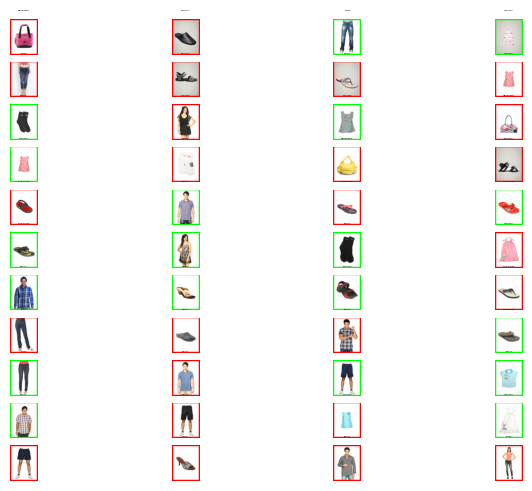

{'Shorts', 'Sandals', 'Shirts', 'Flip Flops', 'Dresses', 'Socks', 'Handbags', 'Jeans', 'Heels'}


In [2]:
# Prova

# using the function visualize_retrieval for the visualization of the retrieval results. Pass the class labels as information to be displayed
predicted = np.random.choice([True, False], len(cropped_images))
print(imgs.shape)
print(cropped_images.shape)
visualize_retrieval(imgs, topN=44, info=class_labels, ok=predicted)

print(set(class_labels))

## 4.1: Funcions d’anàlisi qualitatiu

### Retrieval_by_color (Aleix)

En aquest apartat trobem funcions que ens permetran mostrar les dades resultants del nostre KMeans. Aquestes funcions són:

- `retrieval_by_color`: Aquesta funció ens permetrà obtenir les imatges que tenen uns determinats colors. 

- `check_color_prediction`: Aquesta funció ens permetrà comprovar si els colors que el KMeans ha predit són els que realment tenen les imatges. Es compararà el color predit amb el color 'real' del ground truth. S'ha de tenir en consideració que alguns colors del ground truth són erronis.

- `visualize_retrieval`: Aquesta funció ens permetrà visualitzar les imatges amb l'informació dels colors, si ha estat predit correctament o no i 



In [3]:
# Code
def Retrieval_by_color(imgs, color_labels, query_img):
    """
        Function to retrieve images by color
            Args:
                imgs: array with the images
                color_labels: array with the color labels
                query_img: list of strings with the query images.
                    Example: ['Red'] or ['Red', 'Black']
            Returns:
                imgs_retrieved: array with the images that have the same color as the query image
                color_labels_retrieved: array with the color labels of the images that have the same color as the query image
        """
    color_labels_retrieved = []
    if(len(imgs) != len(color_labels)):
        raise ValueError("imgs and color_labels must have the same length")
    imgs_retrieved = []
    #using zip to iterate over two lists at the same time
    for img, color in zip(imgs, color_labels):
        #check if all the colors in the query_img are in the color of the image
        if(all(x in color for x in query_img)):
            imgs_retrieved.append(img)
            color_labels_retrieved.append(color)
    return imgs_retrieved, color_labels_retrieved

def check_color_prediction(imgs, color_labels, color_labels_predicted, query_img):
    """
        Function to check if the color prediction is correct
            Args:
                imgs: array with the images
                color_labels: array with the color labels
                color_labels_predicted: array with the predicted color labels
                query_img: list of strings with the query images.
                    Example: ['Red'] or ['Red', 'Black']
            Returns:
                ok: array with the boolean values of the correct predictions
    """
    if(len(imgs) != len(color_labels) or len(imgs) != len(color_labels_predicted)):
        raise ValueError("imgs, color_labels and color_labels_predicted must have the same length")
    
    ok = []
    # Check if the color prediction is correct. If the color of the color_labels have all the colors in the query_img and the same as the color_labels_predicted, then it is correct.
    for color, color_predicted in zip(color_labels, color_labels_predicted):
        if(all(x in color for x in query_img)):
            if(all(x in color_predicted for x in query_img)):
                ok.append(True)
            else:
                ok.append(False)
        else:
            if not (all(x in color_predicted for x in query_img)):
                ok.append(True)
            else:
                ok.append(False)
    return ok


# KMeans
km_predicted_colors = []
# for img in imgs:
#     km = KMeans(X=img)
#     km.find_bestK(max_K=11)
#     km_predicted_colors.append(get_colors(km.centroids))


def process_image(img, options):
    km = KMeans(X=img, options=options)
    km.find_bestK(max_K=11)
    return get_colors(km.centroids)

def process_images(imgs, options, parallel=False):
    """
        Function to process a list of images.
            Args:
                imgs: list of images
                options: dictionary with the options for the KMeans
                parallel: boolean to run the processing in parallel or not
            Returns:
                colors: list with the colors of the images
    """
    if parallel:
        from joblib import Parallel, delayed
        return Parallel(n_jobs=2)(delayed(process_image)(img, options) for img in imgs)
    else:
        return [process_image(img) for img in imgs]

(180, 80, 60, 3)


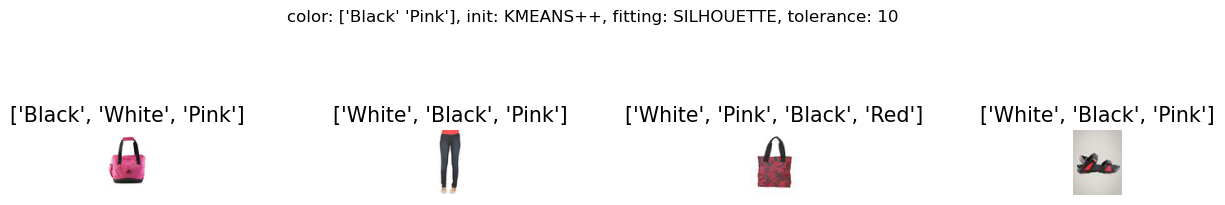

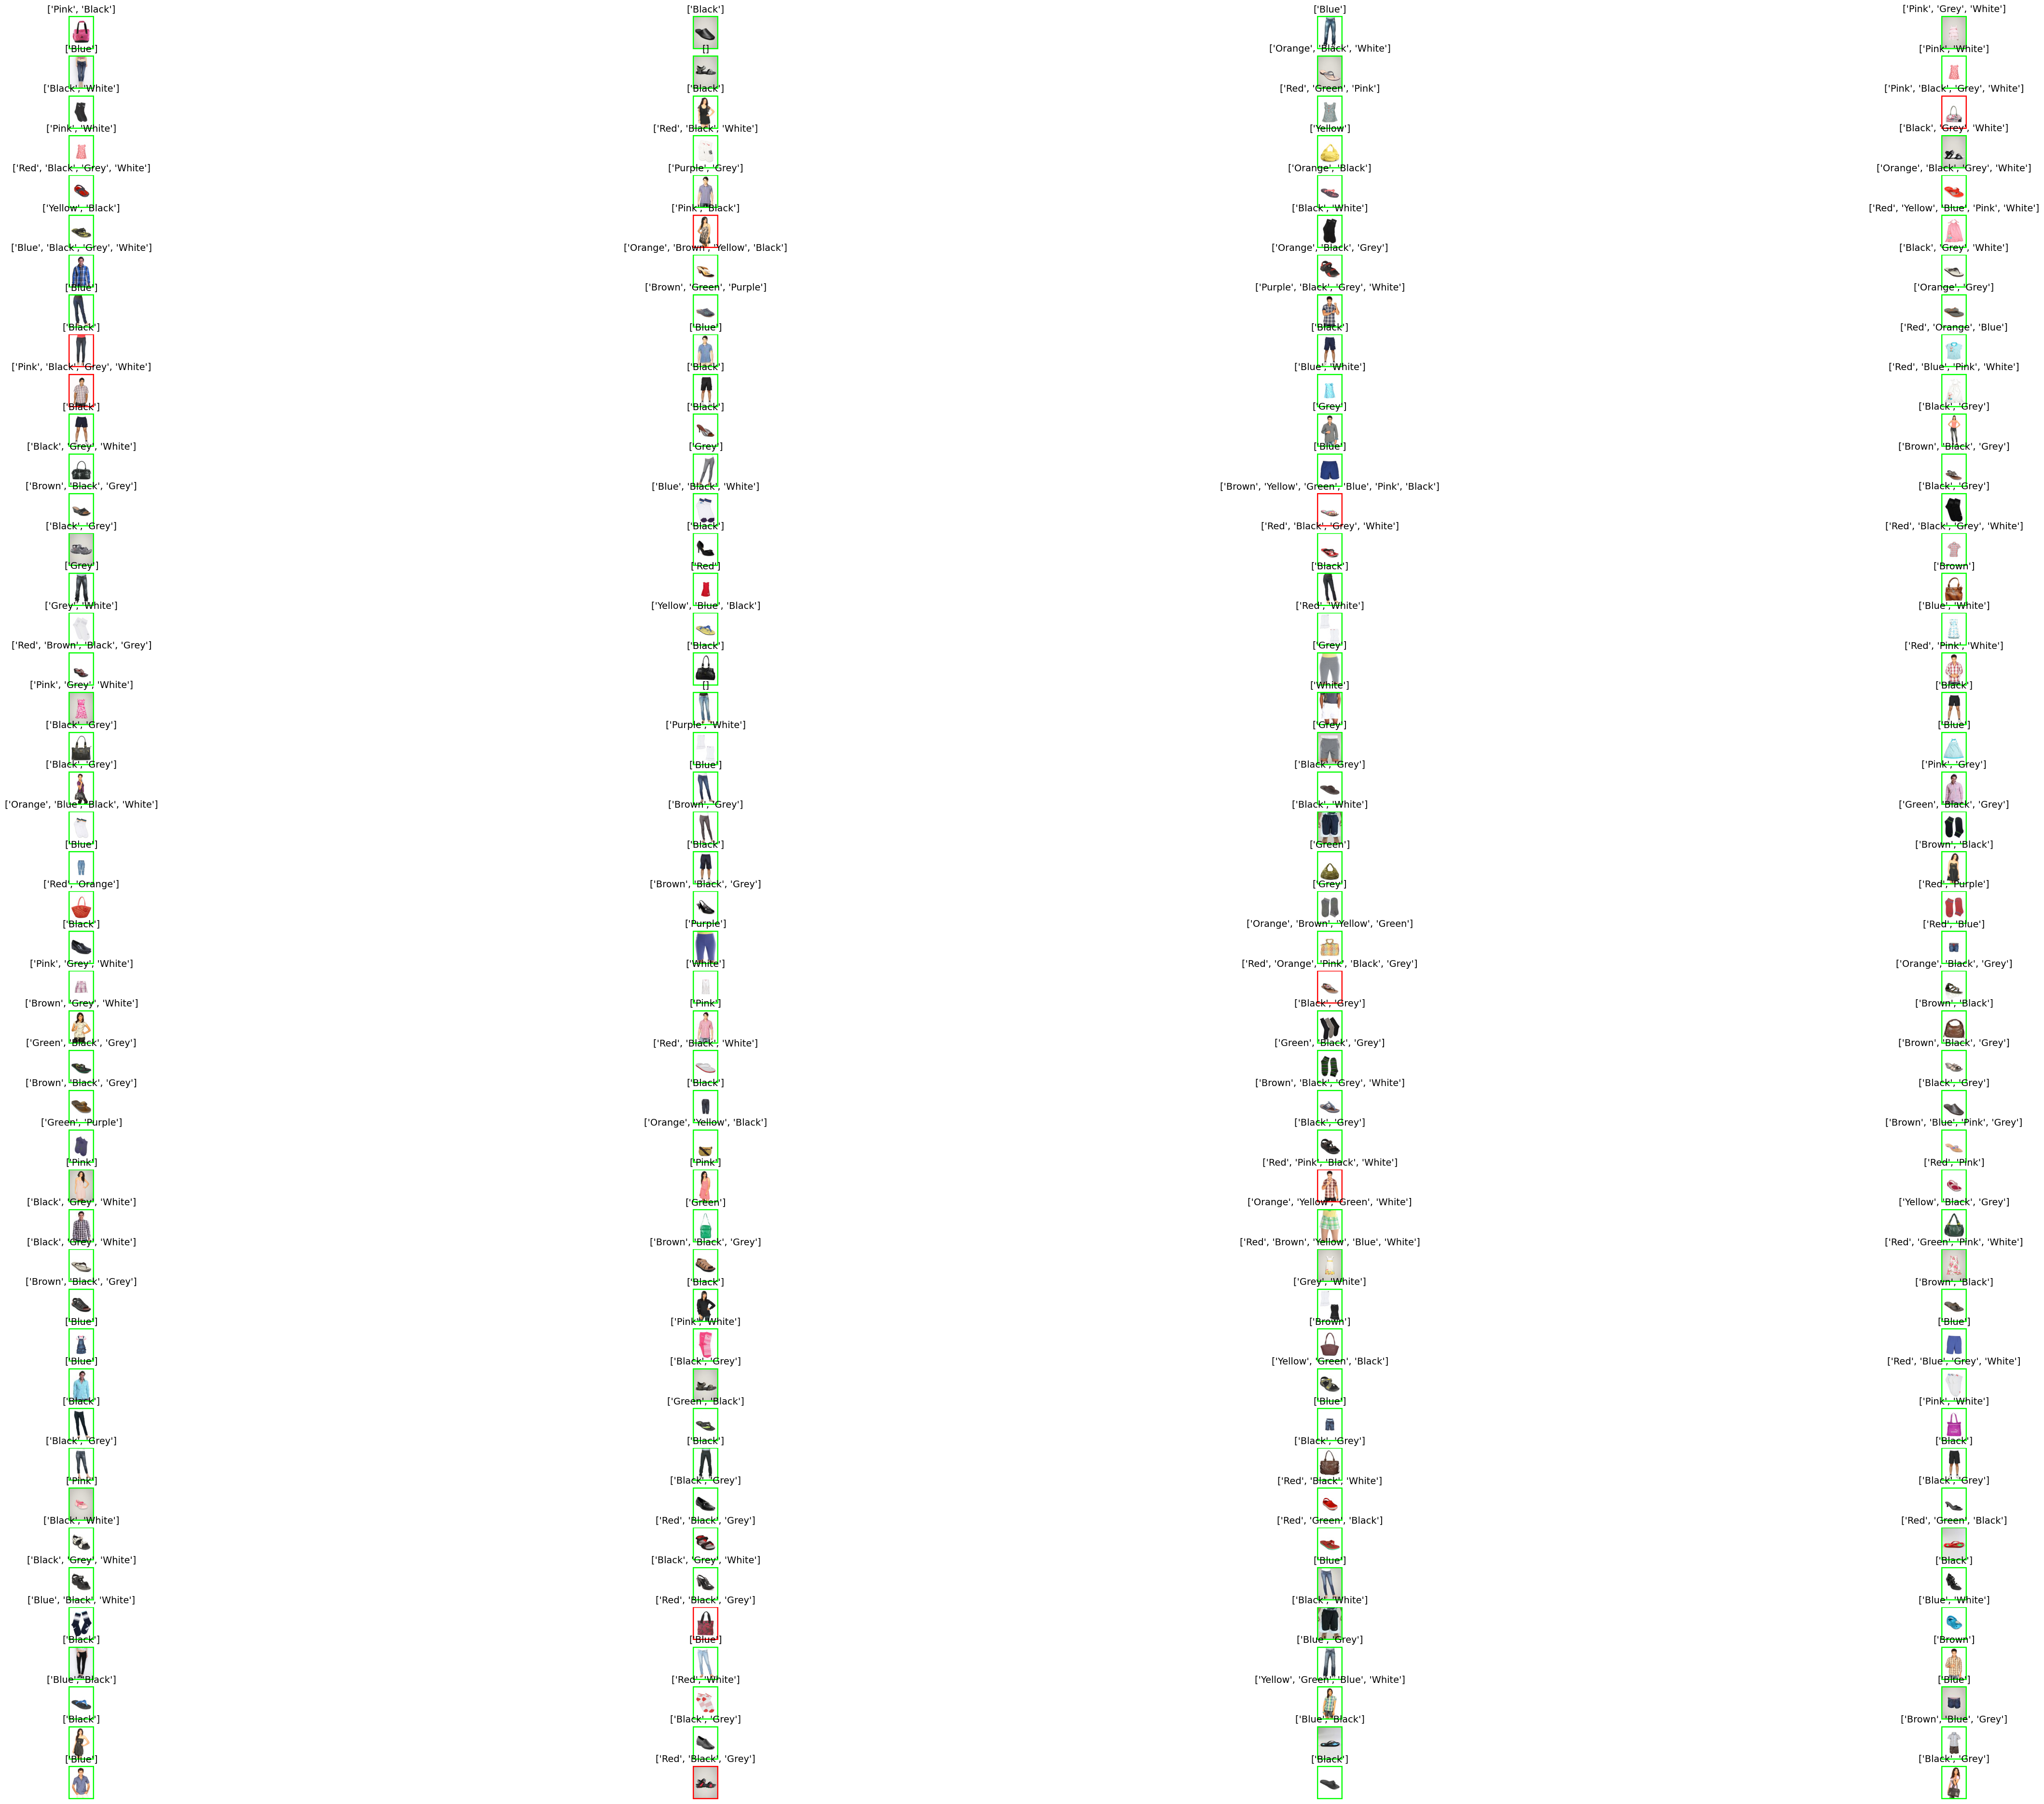

Correct predictions:  95.0 %


In [4]:
# Execution

imgs = imgs[:180]
print(imgs.shape)

query_img = np.array(['Black', 'Pink'])
# options
# one of the best options: options = {'km_init': 'kmeans++', 'fitting': 'silhouette', 'tolerance': 10}
options = {'km_init': 'kmeans++', 'fitting': 'silhouette', 'tolerance': 10}
    
km_predicted_colors = process_images(imgs, options=options, parallel=True)

title = "color: {}, init: {}, fitting: {}, tolerance: {}".format(
    query_img,
    options.get('km_init', 'WCD').upper(),
    options.get('fitting', 'first').upper(),
    options.get('tolerance', '20')
)

imgs_retrieved, colors_retrieved = Retrieval_by_color(imgs, km_predicted_colors, query_img=query_img)
visualize_retrieval(imgs_retrieved, topN=48, info=colors_retrieved, fac_size=2, title=title)
ok = check_color_prediction(imgs, color_labels[:len(imgs)], km_predicted_colors, query_img=query_img)
# Green: Image identified correctly. Red: Image identified incorrectly, can be a false positive or a false negative
visualize_retrieval(imgs, topN=len(imgs), info=color_labels, ok=ok, fac_size=8)
# print ratio of correct predictions
print("Correct predictions: ", np.sum(ok)/len(ok)*100, "%")

### Retrieval_by_shape

En aquest apartat trobem funcions que ens permetran mostrar les dades resultants del nostre KNN. Aquestes funcions són:

- check_shape_prediction(...)
    
    Paràmetres d'entrada
    - prediccions: llista d'strings, llista de les nostres prediccions
    - labels: llista d'strings, llista dels ground_truth

    Paràmetres de sortida:
    - check_list: llista de bools, llista de totes les prediccions encertades

    En aquesta funció es genera una llsita amb totes les prediccions encertades per l'algorisme

- retrieval_by_shape(...)

    Paràmetres d'entrada:
    - train_imgs: numpyarray, mida: (P, N, M, 3), vector de les imatges d'entrenament.
    - train_class_labels: numpyarray, mida: (P, ), vector del ground truth de les imatges d'entrenament
    - test_imgs, numpyarray, mida: (P, N, M, 3), vector de les imatges de test
    - test_class_labels:  numpyarray, mida: (P, ), vector del ground truth de les imatges de test
    - k: int, nombre de veins als que mirar, per defecte = 10

    Paràmetres de sortida:
    - prediccions: llista d'strings, llista de les nostres prediccions 
    - test_class_labels: numpyarray, mida: (P, ), vector del ground truth de les imatges de test
    - ok: llista de bools, llista de totes les prediccions encertades

    En aquesta funció s'inicialitza el KNN, es fan prediccions i es comproven les prediccions amb el ground_truth

- show_predictions(...)

    Paràmetres d'entrada:
    - images:  numpyarray, mida: (P, N, M, 3), vector de les imatges de test
    - prediccions: llista d'strings, llista de les nostres prediccions 
    - labels: llista d'strings, llista dels ground_truth/labels
    - ok: llista de bools, llista de totes les prediccions encertades
    - shape: string o array, peça de roba a identificar, per defecete = ['Jeans']

    En aquesta funció es mostraràn per pantalla totes les prediccions fetes per el nostre KNN per a una o varies peces de roba.

    NOTES:
    - La funció detectarà que es pugui passar un string com a parametre, sempre i quant nomès sigui una peça de roba ( ex: 'Jeans' → [\'Jeans\'], peró 'JeansShorts' → [\'JeansShorts\'] )

A continuació deixo una llista amb tots els tipus de peçes de roba per si es vol testejar el codi:
['Flip Flops', 'Jeans', 'Shirts', 'Sandals', 'Dresses', 'Shorts', 'Heels', 'Socks', 'Handbags']

In [5]:
# Code
import KNN

def check_shape_prediction(prediccions, labels):
    # Fem llista de prediccions correctes
    check_list = [pred == label for pred, label in zip(prediccions, labels)]
    return check_list

    
def retrieval_by_shape(train_imgs, train_class_labels, test_imgs, test_class_labels, k=10, option='simple'):
    # Inicialitzem i entrenem el KNN
    knn = KNN.KNN(train_data=utils.rgb2gray(train_imgs), labels=train_class_labels)

    # Fem les prediccions
    predictions = knn.predict(utils.rgb2gray(test_imgs), k=k, option=option)

    # Comprovem que les validacions siguin correctes
    ok = check_shape_prediction(prediccions=predictions, labels=test_class_labels)

    return predictions, test_class_labels ,ok

def show_predictions(images, prediccions, labels, ok, shape=['Jeans'], option='simple'):
    
    title = "Shape: " + str(shape) + ", Method: " + str(option)
    # Fem que si la entrada és una string s'inclogui dins d'un array
    if type(shape) is str:
        shape = [shape]
    
    # Preparem les llistes que farèm servir per mostrar les dades
    labels_to_print = []
    images_to_print = []
    ok_to_print = []
    for img, pred, label, o in zip(images, prediccions, labels, ok):
        
        # Aquí filtrem per les dades que hem predit i que coincideixen amb els resultats
        if pred in shape:
            labels_to_print.append([pred, label])
            images_to_print.append(img)
            ok_to_print.append(o)
    
    # Transformem llistes en np.numpyarray
    labels_to_print = np.array(labels_to_print)    
    images_to_print = np.array(images_to_print)
    ok_to_print = np.array(ok_to_print)
    
    # Mostrem les dades fent us de la funció 
    visualize_retrieval(images_to_print, topN=len(images_to_print), info=labels_to_print, ok=ok_to_print, fac_size=5, title=title)
    # Mostrem el percentatge de correctes
    print("Correct predictions: ", np.sum(ok_to_print)/len(ok_to_print)*100, "%, Method: ", option)


↓ Execució de prova de les funcions

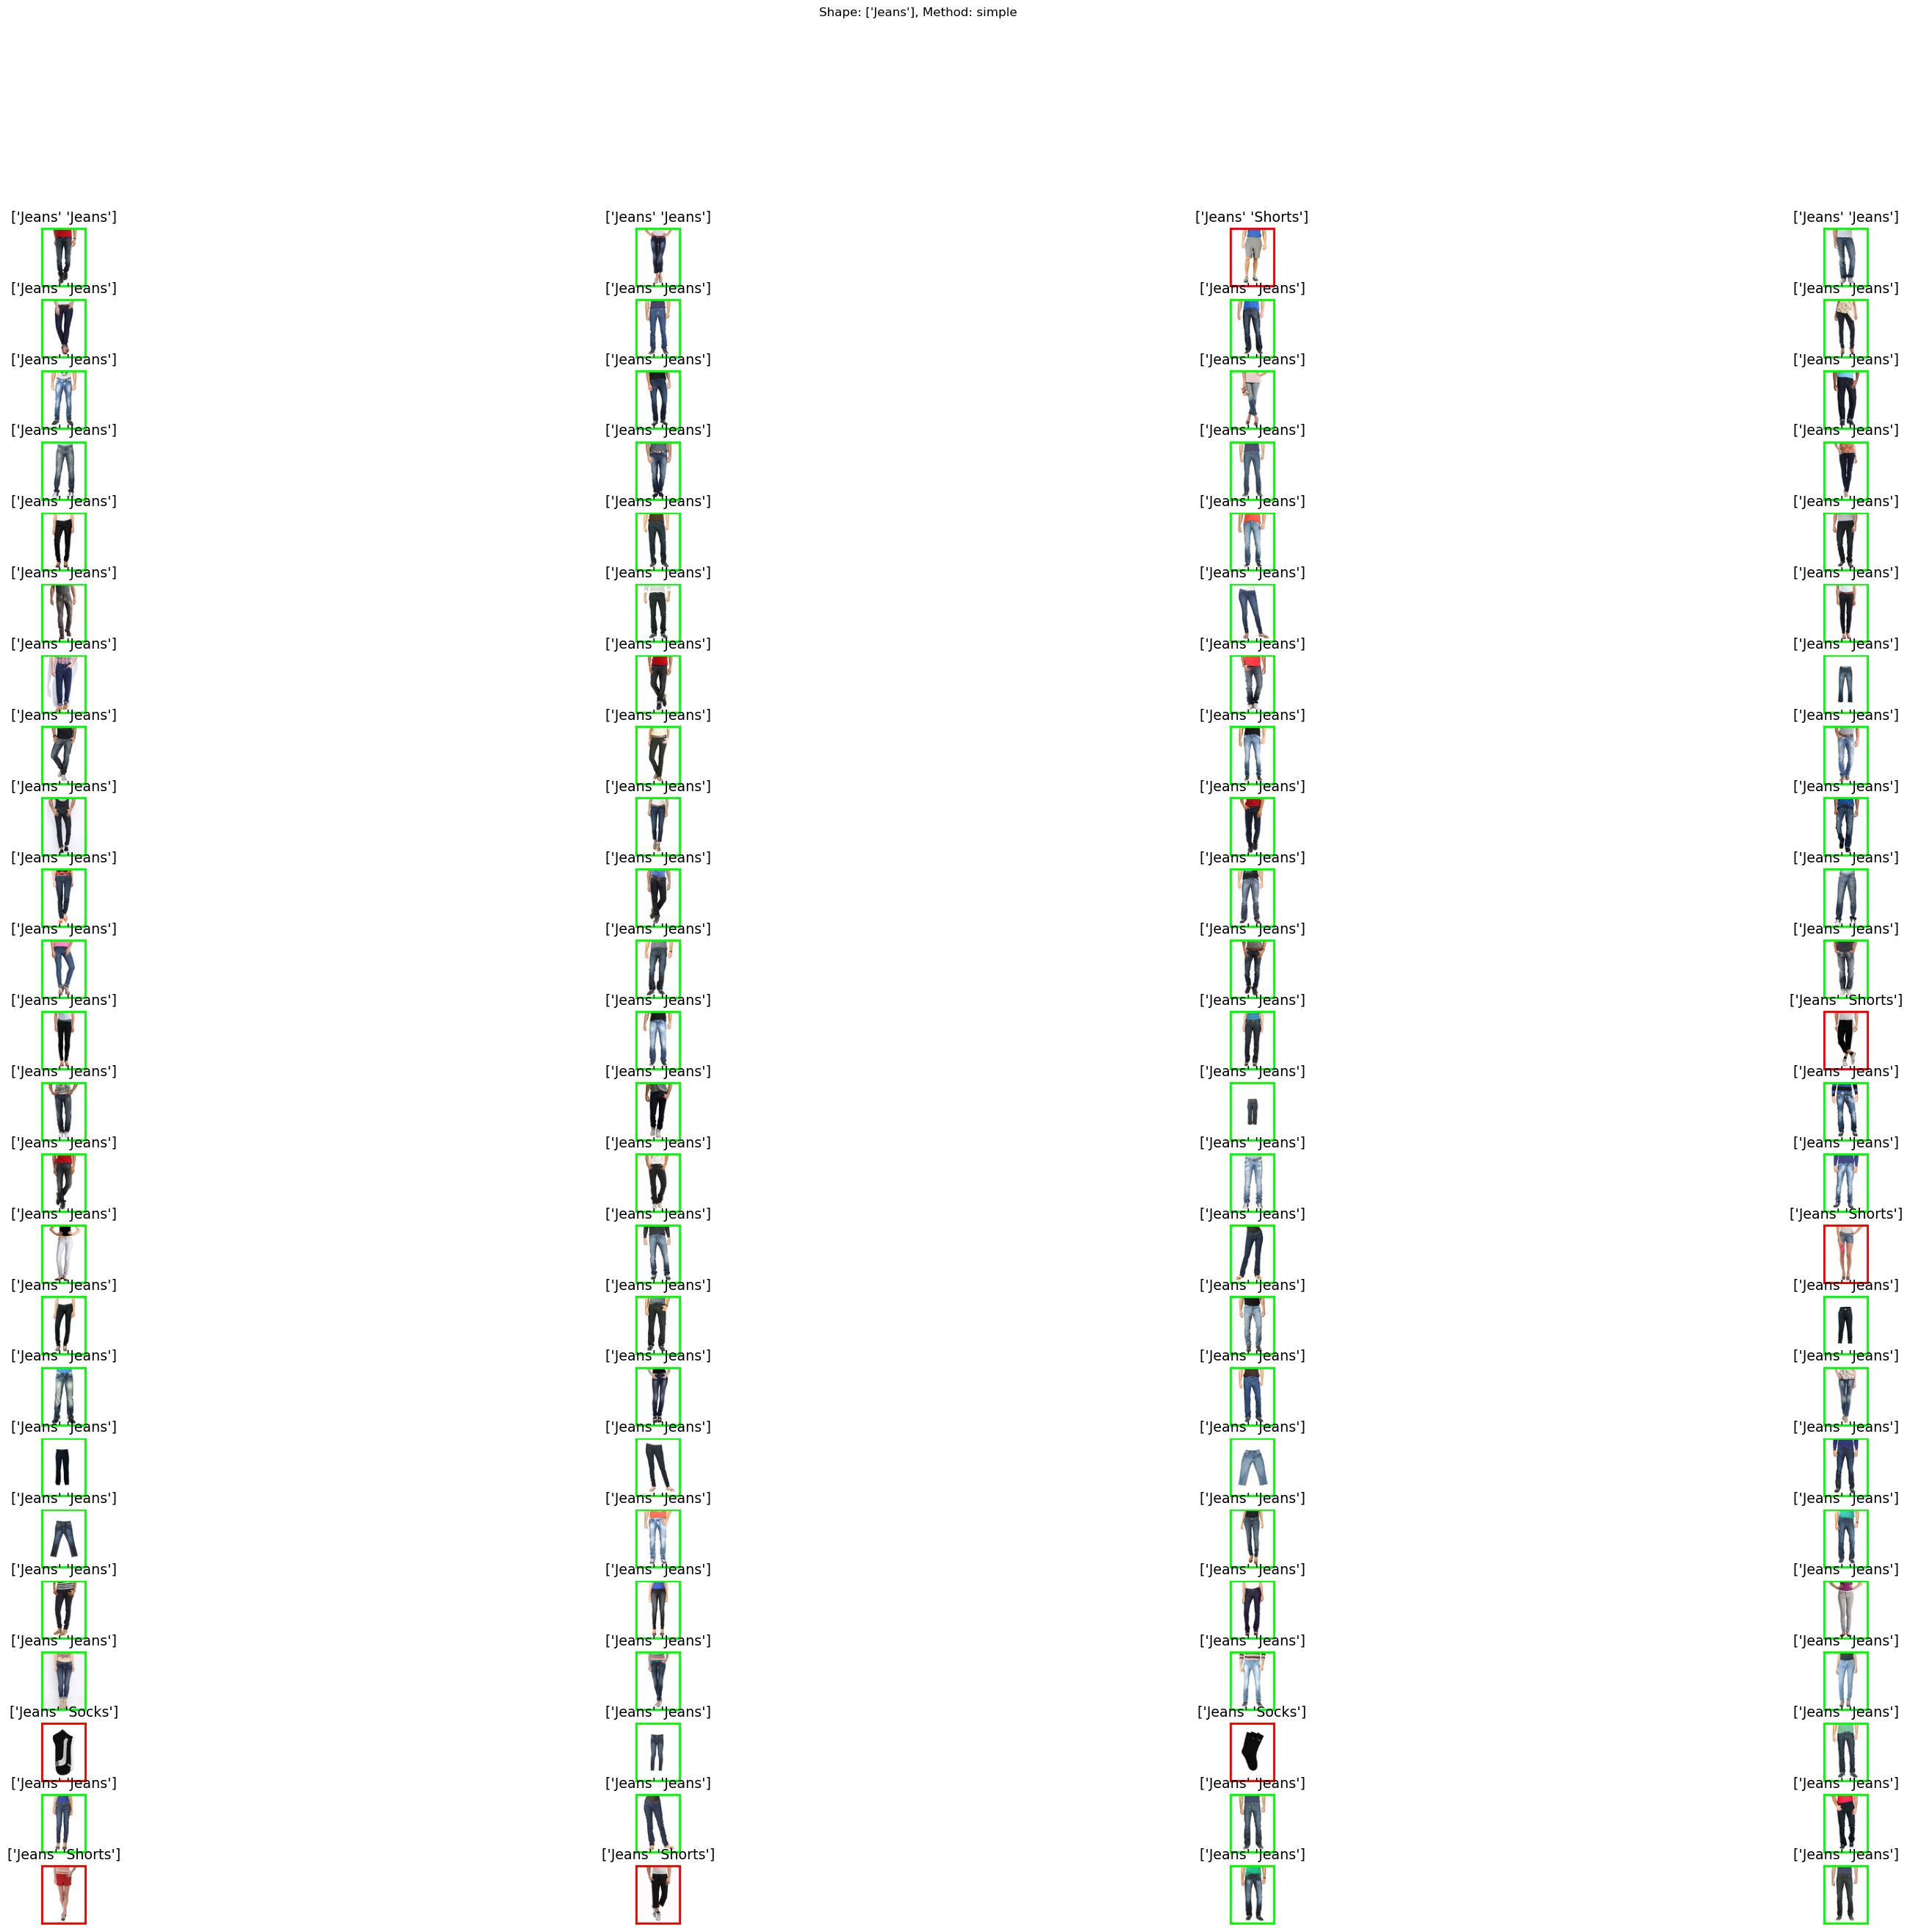

Correct predictions:  92.70833333333334 %, Method:  simple


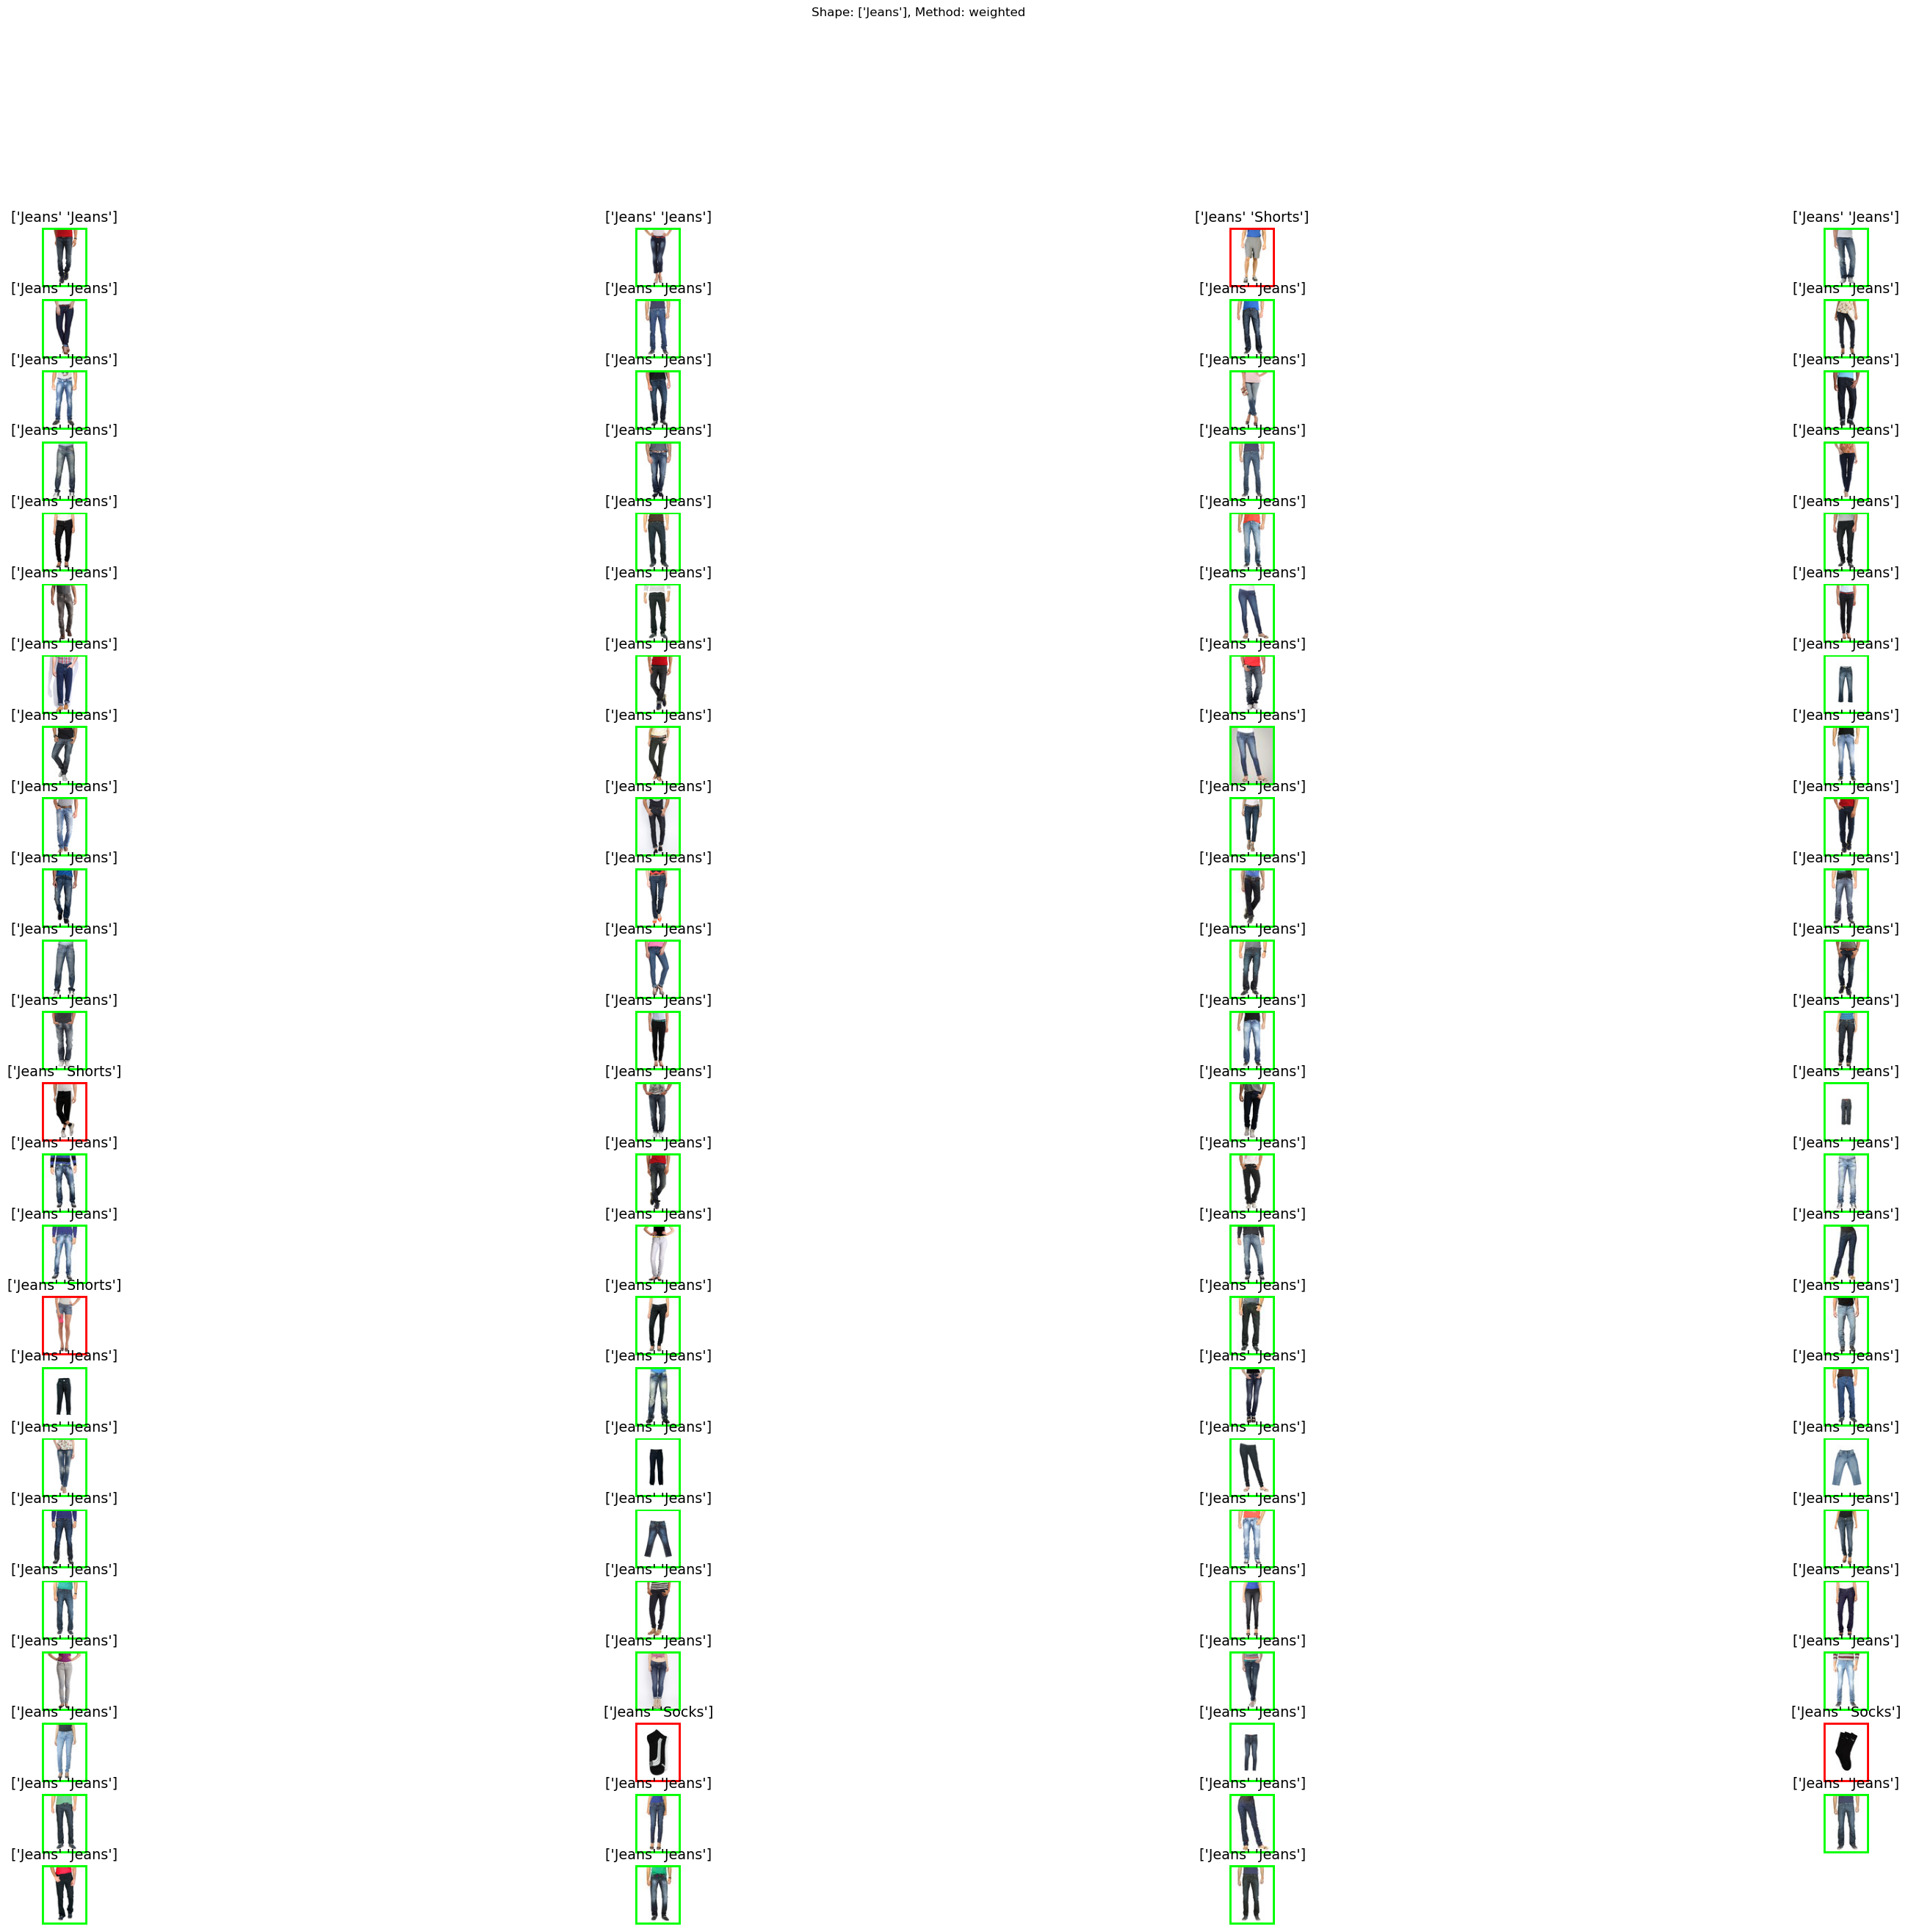

Correct predictions:  94.73684210526315 %, Method:  weighted


In [6]:
# Execution
# Carreguem les imatges
train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, test_color_labels = load_train()

option = 'simple'
# Entrenem i fem les prediccions del KNN
predictions, labels, ok = retrieval_by_shape(train_imgs, train_class_labels, test_imgs, test_class_labels, k=10, option=option)

# Mostrem els resultats
show_predictions(images=test_imgs, prediccions=predictions, labels=labels, ok=ok, shape=['Jeans'], option=option)

option = 'weighted'
# Entrenem i fem les prediccions del KNN
predictions, labels, ok = retrieval_by_shape(train_imgs, train_class_labels, test_imgs, test_class_labels, k=10, option=option)

# Mostrem els resultats
show_predictions(images=test_imgs, prediccions=predictions, labels=labels, ok=ok, shape=['Jeans'], option=option)

#### Prediccions per classe

A continuació es mostren els resultats del KNN per classes

### Retrieval_combined (Aleix)

In [7]:
# Code
import KNN
import Kmeans
def retrieval_combined(train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, test_color_labels, k=10, option='simple'):
    # Inicialitzem i entrenem el KNN
    knn = KNN.KNN(train_data=utils.rgb2gray(train_imgs), labels=train_class_labels) 
    # Fem les prediccions   
    predictions = knn.predict(utils.rgb2gray(test_imgs), k=k, option=option)
    # Comprovem que les validacions siguin correctes
    ok = check_shape_prediction(prediccions=predictions, labels=test_class_labels)
    # Inicialitzem i entrenem el KMeans
    km = Kmeans.KMeans(X=train_imgs, options={'km_init': 'kmeans++', 'fitting': 'silhouette', 'tolerance': 10})
    km.find_bestK(max_K=11)
    # Fem les prediccions
    km_predictions = get_colors(km.centroids)
    # Comprovem que les validacions siguin correctes
    ok_km = check_color_prediction(imgs=train_imgs, color_labels=train_color_labels, color_labels_predicted=km_predictions, query_img=['Black', 'Pink'])
    # Combinem les prediccions
    combined_predictions = []
    for pred, ok, ok_km in zip(predictions, ok, ok_km):
        if ok and ok_km:
            combined_predictions.append(pred)
        else:
            combined_predictions.append('Other')
    return combined_predictions, test_class_labels, ok


## Funcions d’anàlisi quantitatiu

### Kmean_statistics

Hem realitzat dues funcions per a la execució d'questa part. Procedim a explicar-les:

- plot_wcd_iter_temps_and_means(...): 
    
    Paràmetres d'entrada:
    - heur: vector de vectors, heurística, per defecte = None
    - iter: vector de vectors, iteracions, per defecte = None 
    - temps: vector de vectors, temps, per defecte = None
    - Kmax: int, nombre maxim de K, per defecte = 10
    - nom_heur: string, nom de la gràfica de la Heurística, per defecte = 'Heurística'

    Es mostraràn 3 plots amb les dades dels vectors que es passin per paràmetres, es mostraràn les dades de puntets de colors i la mitja en una linea negra. 

    Cal tenir en compte un parell de coses:
    - Aquesta funció NO calcula res, nomès mostra
    - En cas de no voler mostrar alguna cosa no passeu res com a paràmetre 
    - Podeu indicar el nom de la heurística peró res més


- Kmean_statistics(...):
    
   Paràmetres d'entrada: 
    - imgs: set d'imatges d'entrada
    - kmax: int, nombre maxim de K, per defecte = 10
    - num_imatges, nombre d'imatges per les quals iterar, per defecte = 10

    Return:
    - heur_lst: vector de vectors, llista del les heurístiques 
    - iter_lst: vector de vectors, llista del les iteracions
    - temps_lst: vector de vectors, llista dels temps de cada fit

    Iterem per totes les imatges i executem el fit tatnes vegades com el vector K, es guardaràn el nombre d'iteracions, les heurístiques finals, i el temps que s'ha trigat en fer el fit de cada K. 

In [8]:
# Aquesta funció serveix per a fer 3 plots, de la heurística 
def plot_wcd_iter_temps_and_means(heur = None, iter=None, temps=None, Kmax=10, nom_heur='Heurística'):
    
    # Aquesta comanda serveix per a dir el nombre de columnes i files dels plots, a més de les dimensions de tot plegat
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    
    # Avans de mostrar qualsevol dada comprovo que aquesta existeixi 
    if heur is not None:
        
        # Primer mostrem totes les dades en "linies" individuals
        
        i = 0   # i serveix per a controlar l'index i actualitzar el label de la imatge
        max_height = max(heur[0])   # max_height serveix per a trobar el valor màxim del plot, és util per a mesurar les dimensions del cada plot
        
        # itero per cada element de la mètrica en questió, el mostro i actualitzo max_height si s'escau
        for h in heur:
            # aquesta funció afegeix a la figura ax[0][0] la recta h, notem que es guarden les rectes anteriorment asignades a ax[0][0]
            ax[0].plot(range(2,2+Kmax-1), h, label=f'imatge{i}', linestyle='dotted', ) # el range(...) indica de on a on va l'eix X
            
            # Busquem si hi ha la major altura i augmentem i
            if max_height < max(h):
                max_height = max(h)
            i+=1
        
        # Acontinuació fem i mostrem la mitjana de totes les linies
        heur_array = np.array(heur)
        means = np.mean(heur_array, axis=0)
        ax[0].plot(range(2,2+Kmax-1), means, label='Average heurístic value', linewidth=2, color='black')
        
        
        # Poso titols al plot i als eixos, i mostro la llegenda
        ax[0].set_title(nom_heur + ' per K')
        ax[0].set_xlabel('K')
        ax[0].set_ylabel(nom_heur)
        
        # Mostrem la llegenda en cas de que hi hagin poques linies
        if(len(heur) <= 5):
            ax[0].legend() 
        
        # Aquí indico les dimensions del plot, per a que tingui una forma ben maca :)
        ax[0].set_aspect(aspect=Kmax/max_height)
        ax[0].figure.set_size_inches(20, 20)
        
            
    if iter is not None:

        i, max_height = 0, max(iter[0])
        for it in iter:
            ax[1].plot(range(2,2+Kmax-1), it, label=f'imatge{i}', linestyle='dotted',)
            
            if max_height < max(it):
                max_height = max(it)
            i += 1
            
        iter_array = np.array(iter)
        means = np.mean(iter_array, axis=0)  
        ax[1].plot(range(2,2+Kmax-1), means, label='Average iterations', linewidth=2, color='black') 
            
        ax[1].set_title('Number of iterations needed per K')
        ax[1].set_xlabel('K')
        ax[1].set_ylabel('# Iterations')
        
        if(len(iter) <= 5):
            ax[1].legend() 
        
        ax[1].set_aspect(aspect=Kmax/max_height)
        ax[1].figure.set_size_inches(20, 20)
        
  
    
    if temps is not None:
        i, max_height = 0, max(temps[0])
        for t in temps:
            ax[2].plot(range(2,2+Kmax-1), t, label=f'imatge{i}',linestyle='dotted')
            if max_height < max(t):
                max_height = max(t)
            i += 1
        
        time_array = np.array(temps)
        means = np.mean(time_array, axis=0)
        ax[2].plot(range(2,2+Kmax-1), means, label='Average fit time',linewidth=2, color='black')
        
        
        ax[2].set_title('Execution time of each Kmeans fit')
        ax[2].set_xlabel('K')
        ax[2].set_ylabel('Time')
        
        if(len(temps) <= 5):
            ax[2].legend() 
            
        ax[2].set_aspect(aspect=Kmax/max_height)
        ax[2].figure.set_size_inches(20, 20)

    
    
    # Ajusto l'espai que hi ha entre plots per a que es vegi bé
    plt.subplots_adjust(wspace=.7) 

    plt.show()

In [9]:
from Kmeans import KMeans
import time

# Aquesta funció avaluarà la funcuó fit, d'una fomrma semblant a la que implenentariem un find_best_k()
def Kmean_statistics(imgs, kmax, num_imatges=10):
    
    heur_lst, iter_lst, temps_lst = [], [], []
    #for ix, input in enumerate(test_cases['input']):
    for input in imgs[0:num_imatges]:
    
        # Inicialitzem una nova classe K-Means amb la nova imatge
        km = KMeans(input)
        
        # Calculem les estadístiques
        heur, iter, temps = [], [], []
        
        # Fem un model fit per a cada K diferent dins del rang [2, Kmax] i en guardem les mètriques demanades
        for i in range(2, kmax+1):
            km.num_iter = 0
            km.K = i
            
            # calculem el temps que es triga en fer el fit (en segons)
            start_time = time.time()
            km.fit()
            end_time = time.time()
            
            
            heur.append(km.withinClassDistance())
            iter.append(km.num_iter)
            temps.append(end_time - start_time)   

        # Afegim les noves metriques al les llistes de llistes
        heur_lst.append(heur)
        iter_lst.append(iter)
        temps_lst.append(temps)
    
    return heur_lst, iter_lst, temps_lst


↓ Execució de prova de les funcions

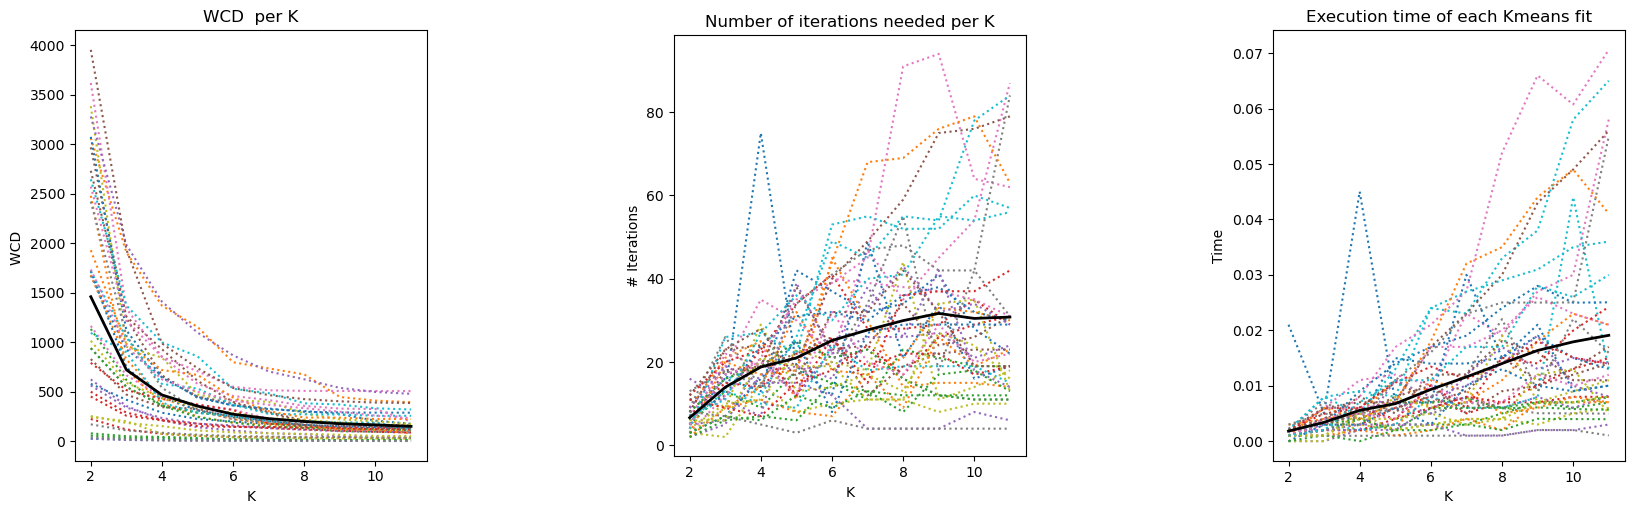

In [10]:
# Creem les llistes de dades i executem la funció Kmean_statistics per cada imatge 
K_MAX = 11
NUM_IMATGES = 40

# Carreguem dades
test_imgs, test_imgs_cropped, test_class_labels, test_color_labels, _ = load_cropped()

# Calculem les estadistiques
wcd, iter, temps = Kmean_statistics(imgs=test_imgs_cropped, kmax=K_MAX, num_imatges=40, )
    
# Mostrem els resultat 
plot_wcd_iter_temps_and_means(heur=wcd, iter=iter, temps=temps, Kmax=K_MAX, nom_heur='WCD ')

### Get_shape_accuracy (Aleix)

### Get_color_accuracy

En aquest apartat hem calculat diferents les metriques: True Positive (TP), False Positive(FP), False Negative(FN) i l'average per a un total d'N imatges , extretes del extended dataset, per a dos casos diferents, quan tenim en compte les repeticions com a false negative i quan no.

Per repeticions entenem a dos centroides que generen els mateixos colors desprès de fer un fit() (ex: [\"Blue\"], [\"Blue\"], [\"Pink\"] → es repeteix el \"Blue\" dos cops). A més donem per sentat que no existeixen repeticions de colors al Ground-Truth

Per a cada imatge del expanded kmenas següim el següent el procediment:
    
1. Realitzar el K-Means (findBestK & fit)    
2. Trobem els colors equivalents als centroides 
3. Actualitzem el nombre de Ks correctes (o no)
4. ACtualitzem el total de TP, FP, FN i el nombre de colors repetits en els resultats
5. Calculem l'accuracy
6. Mostrem els resultats

Aquesta funció (get_colors_accuracy(...)) serà més util més endavant a la hora de mirar eficiencies d'Heuristiques.

In [11]:
from Kmeans import KMeans
from Kmeans import get_colors
import copy

MAX_COLORS = 11
color_indexes = {'White': 0, 'Grey': 1, 'Black': 2, 'Orange': 3, 'Red': 4, 'Brown': 5, 'Pink': 6, 'Blue': 7, 'Green': 8, 'Purple' : 9, 'Yellow' : 10, 'None' : 11}

def get_colors_accuracy(imatges , labels, num_imatges=20, repeated_accounted=1, options=None):
    
    # Inicialitzem les matrius i altres metriques
    trues_and_false_matrix = [0, 0, 0, 0] # Positive, False Positive, False Negative, Repeated 
    encerts_k = [0, 0] # Encert, Falla
    
    
    for image, true_colors in zip(imatges[0:num_imatges], labels[0:num_imatges]):
        
        # Inicialitzem un K-Means, trobem la millor K i predim els centroides 
        km=KMeans(image, options=options)
        km.find_bestK(max_K=MAX_COLORS)
        #km.fit()
        centroids = km.centroids

        # A partir dels centroides trobem els colors
        predicted_colors = get_colors(centroids=centroids)
        true_colors = copy.deepcopy(true_colors)
        
        #print(predicted_colors)
        #print(len(predicted_colors))
        #print(true_colors)
        #print(len(true_colors))
        
        
        # Calculem l'encert entre la K calculada i la K verdadera
        if km.K is len(true_colors):
            encerts_k[0] += 1
        else: 
            encerts_k[1] += 1
        
        
            
        # a in b → Correct
        # a not in b → False Positive
        # b not in a → False Negative
        # len a in a > 1 → Repetit
        
        # Actualitzem la matriu
        colors_done = [] # Aquesta llista ens permet recordar els colors vistos
        for predicted_color in predicted_colors:
            # REPETITS: Marquem color repetit si n'hi ha mes de 2 i no l'hem vist encara
            if predicted_color not in colors_done:
                if predicted_colors.count(predicted_color) > 1:
                    # Marquem color repetit
                    trues_and_false_matrix[3] += 1 
                    
                    # Marquem el color com a ja analitzat
                    colors_done.append(predicted_color)
                
            # TRUE:
            if predicted_color in true_colors:
                # Marquem True Positive
                trues_and_false_matrix[0] += 1
                
                # Eliminem color del Ground Truth
                true_colors.remove(predicted_color) # Donem per sentat que al Ground Truth no hi han colors repetits.

                
            # FALSE POSITIVE:
            if predicted_color not in true_colors:
                if predicted_color in colors_done:
                    trues_and_false_matrix[1] += repeated_accounted 
                else:
                    # Marquem False Positive
                    trues_and_false_matrix[1] += 1 
                
        # FALSE NEGATIVE
        trues_and_false_matrix[2] += len(true_colors)
        
                
    
    # accuracy K-Means
    accuracy =  trues_and_false_matrix[0] / (trues_and_false_matrix[0] + trues_and_false_matrix[1] + trues_and_false_matrix[2]) * 100
    
    
    # Print results
    if repeated_accounted:
        print("Resultats Kmeans (repeated acounted for):\n")
    else:
        print("Resultats Kmeans (repeated NOT acounted for):\n")
    
    print("Encerts K:", encerts_k[0])
    print("Falles K:", encerts_k[1])
    print("Percentatge d'encerts K", encerts_k[0]/(encerts_k[0]+encerts_k[1])*100, "%\n")
    
    print("__________________________")
    print("| True Positives  | ", trues_and_false_matrix[0], "|")
    print("|_________________|______|")
    print("| False Positives | ", trues_and_false_matrix[1], "|")
    print("|_________________|______|")
    print("| False Negatives | ", trues_and_false_matrix[2], "|")
    print("|_________________|______|")
    print("| Repeated        | ", trues_and_false_matrix[3], "|")
    print("|_________________|______|")
    
    print("\Accuracy = ", accuracy, "%\n\n")
    
    
    #return trues_and_false_matrix, accuracy

↓ Execució de prova de les funcions

In [12]:
test_imgs, test_imgs_cropped, test_class_labels, test_color_labels, _ = load_cropped()

options = {'km_init': 'kmeans++', 'fitting': 'silhouette', 'tolerance': 10}

#confusion_matrix, accuracy_list, accuracy_mean = get_colors_accuracy(num_imatges=len(test_imgs))
get_colors_accuracy(imatges=test_imgs_cropped, labels=test_color_labels, num_imatges=len(test_imgs), repeated_accounted=1, options=options)
get_colors_accuracy(imatges=test_imgs_cropped, labels=test_color_labels, num_imatges=len(test_imgs), repeated_accounted=0, options=options)


Resultats Kmeans (repeated acounted for):

Encerts K: 45
Falles K: 135
Percentatge d'encerts K 25.0 %

__________________________
| True Positives  |  238 |
|_________________|______|
| False Positives |  648 |
|_________________|______|
| False Negatives |  156 |
|_________________|______|
| Repeated        |  139 |
|_________________|______|
\Accuracy =  22.84069097888676 %


Resultats Kmeans (repeated NOT acounted for):

Encerts K: 39
Falles K: 141
Percentatge d'encerts K 21.666666666666668 %

__________________________
| True Positives  |  240 |
|_________________|______|
| False Positives |  252 |
|_________________|______|
| False Negatives |  154 |
|_________________|______|
| Repeated        |  140 |
|_________________|______|
\Accuracy =  37.15170278637771 %




## Millores als mètodes de classificació

### Inicializations de Kmeans

'kmeans++': selects K points as centroids based on the KMeans++ algorithm. The first centroid is chosen randomly and the rest are chosen based on the distance to the closest centroid

El mètode `kmeans++` és una tècnica per inicialitzar els centroides en l'algorisme K-means. L'objectiu d'aquesta tècnica és proporcionar una inicialització que pot conduir a una millor i més ràpida convergència de l'algorisme.

En lloc de seleccionar aleatòriament tots els centroides inicials, com es fa en l'algorisme K-means estàndard, 'kmeans++' selecciona el primer centreide de manera aleatòria i després selecciona els centroides restants de manera que estiguin el més lluny possible dels centroides ja seleccionats.

Això es fa calculant la distància de cada punt a el centreide més proper i utilitzant aquestes distàncies per calcular una probabilitat per a cada punt de ser el següent centreide. Els punts que estan més lluny dels centroides existents tenen una probabilitat més alta de ser seleccionats com a següent centreide.

In [13]:
# Code

### Diferents heurístiques per BestK

In [14]:
# Code



### Find_BestK

In [15]:
# Code

### Features for KNN


El mètode `get_class_weighted` és una implementació de l'algorisme k-Nearest Neighbors (k-NN) que utilitza una votació ponderada per distància per a la predicció de classes. En aquest mètode, cada veí contribueix a la predicció d'un punt de prova, però la contribució de cada veí no és igual: és inversament proporcional a la seva distància al punt de prova. Això significa que els veïns més propers tenen més influència en la predicció que els veïns més llunyans.

En resum, el mètode `get_class_weighted` calcula la classe d'un punt de prova com la classe que té la suma màxima de pesos entre els k veïns més propers del punt de prova, on el pes de cada veí és inversament proporcional a la seva distància al punt de prova.

Aquí teniu una explicació detallada del codi:

1. `weighted_votes = []`: Aquesta és una llista per emmagatzemar la classe predita per a cada punt de prova.

2. El bucle `for i in range(self.neighbors.shape[0])` itera sobre cada punt de prova.

3. `neighbor_labels = self.neighbors[i]`: Aquesta línia obté les etiquetes dels veïns del punt de prova i-èssim.

4. `neighbor_distances = self.distances[i]`: Aquesta línia obté les distàncies dels veïns del punt de prova i-èssim.

5. `weight_dict = {}`: Aquest és un diccionari per emmagatzemar el pes total de cada classe.

6. El bucle `for j in range(len(neighbor_labels))` itera sobre cada veí del punt de prova i-èssim.

7. `label = neighbor_labels[j]`: Aquesta línia obté l'etiqueta del veí j-èssim.

8. `distance = neighbor_distances[j]`: Aquesta línia obté la distància del veí j-èssim.

9. `weight = 1 / (distance + 1e-5)`: Aquesta línia calcula el pes del vot del veí j-èssim com l'invers de la distància.

10. Les següents línies afegeixen el pes al pes total de la classe corresponent.

11. `predicted_label = max(weight_dict.items(), key=lambda item: item[1])[0]`: Aquesta línia troba l'etiqueta amb el pes total màxim i l'afegeix a la llista de prediccions.

12. Finalment, `return np.array(weighted_votes)` converteix la llista de prediccions en un array de numpy i el retorna.